In [1]:
import os
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, count, round, stddev, min as spark_min, max as spark_max
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from datetime import datetime
import json
import matplotlib.pyplot as plt

In [2]:
class Config:
    TRAIN_PATH = '../data/train.parquet'
    TEST_PATH = '../data/test.parquet'
    LISTINGS_PATH = '../data/listings.parquet'
    MODEL_PATH = '../data/xgboost_model_baseline'

    # Optimized XGBoost Parameters
    N_ESTIMATORS = 200  # Increased for better learning
    MAX_DEPTH = 5  # Reduced to prevent overfitting
    LEARNING_RATE = 0.05  # Reduced for better convergence
    SUBSAMPLE = 0.85
    COL_SAMPLE_BY_TREE = 0.85
    MIN_CHILD_WEIGHT = 3  # Regularization
    GAMMA = 0.1  # Minimum loss reduction
    REG_ALPHA = 0.1  # L1 regularization
    REG_LAMBDA = 1.0  # L2 regularization
    VALIDATION_SIZE = 0.2  # Validation set size for monitoring
    RANDOM_STATE = 42


config = Config()

In [3]:
# Initialize Spark
spark = SparkSession.builder \
    .appName("AirbnbXGBoost_Baseline") \
    .master("local[*]") \
    .config("spark.driver.memory", "4g") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .getOrCreate()

print(f"Spark Session created. Version: {spark.version}")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/12/01 14:49:15 WARN Utils: Your hostname, nnnnnn.local, resolves to a loopback address: 127.0.0.1; using 192.168.73.175 instead (on interface en0)
25/12/01 14:49:15 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/01 14:49:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/12/01 14:49:16 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/12/01 14:49:16 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
25/12/01 14:49:16 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


Spark Session created. Version: 4.0.1


In [4]:
print("Loading data...")

if not os.path.exists(config.TRAIN_PATH) or not os.path.exists(config.TEST_PATH):
    raise FileNotFoundError("Train/Test data not found. Please run the previous data prep step first.")

if not os.path.exists(config.LISTINGS_PATH):
    raise FileNotFoundError("Listings data not found. Please run the previous data prep step first.")

# Load Spark DataFrames
train_spark = spark.read.parquet(config.TRAIN_PATH)
test_spark = spark.read.parquet(config.TEST_PATH)
listings_spark = spark.read.parquet(config.LISTINGS_PATH)

# Cache for faster iteration
train_spark.cache()
test_spark.cache()
listings_spark.cache()

print(f"Train count: {train_spark.count():,}")
print(f"Test count:  {test_spark.count():,}")
print(f"Listings count: {listings_spark.count():,}")

Loading data...


Train count: 50,410
Test count:  12,603
Listings count: 12,004


In [5]:
# Enhanced Feature Engineering (NO DATA LEAKAGE)
print("\nCreating CLEAN features for XGBoost (no target-derived features)...")

# CLEAN User features - counts only (NO rating-based statistics)
print("  - Computing clean user statistics (counts only)...")
user_stats = train_spark.groupBy("user_id").agg(
    count("item_id").alias("user_review_count")
    # REMOVED: avg("rating"), stddev("rating"), min("rating"), max("rating")
    # These caused data leakage as they were derived from the target variable
).withColumnRenamed("user_id", "user_id_stats")

# CLEAN Item features - counts only (NO rating-based statistics)
print("  - Computing clean item statistics (counts only)...")
item_stats = train_spark.groupBy("item_id").agg(
    count("user_id").alias("item_review_count")
    # REMOVED: avg("rating"), stddev("rating"), min("rating"), max("rating")
    # These caused data leakage as they were derived from the target variable
).withColumnRenamed("item_id", "item_id_stats")

# 3. Join clean user and item stats to train data
print("  - Joining clean features to train data...")
train_with_features = train_spark \
    .join(user_stats, train_spark.user_id == user_stats.user_id_stats, "left") \
    .join(item_stats, train_spark.item_id == item_stats.item_id_stats, "left") \
    .drop("user_id_stats", "item_id_stats")

# 4. Join listings features
print("  - Joining listings metadata...")
train_with_features = train_with_features \
    .join(listings_spark, train_with_features.listing_id == listings_spark.listing_id, "left")

# 5. Apply same feature engineering to test data
print("  - Applying clean features to test data...")
test_with_features = test_spark \
    .join(user_stats, test_spark.user_id == user_stats.user_id_stats, "left") \
    .join(item_stats, test_spark.item_id == item_stats.item_id_stats, "left") \
    .drop("user_id_stats", "item_id_stats") \
    .join(listings_spark, test_spark.listing_id == listings_spark.listing_id, "left")

print("✓ Clean feature engineering complete (NO DATA LEAKAGE)")


In [6]:
# Prepare data for XGBoost (NO DATA LEAKAGE)
print("\nPreparing data for XGBoost...")

# Convert to Pandas for XGBoost
print("  - Converting to Pandas DataFrames...")
train_df = train_with_features.toPandas()
test_df = test_with_features.toPandas()

print(f"  - Train shape: {train_df.shape}")
print(f"  - Test shape: {test_df.shape}")

# CLEAN feature columns - NO target-derived statistics
# REMOVED: user_avg_rating, user_rating_std, user_min_rating, user_max_rating
# REMOVED: item_avg_rating, item_rating_std, item_min_rating, item_max_rating
feature_cols = [
    'user_id', 'item_id',
    'user_review_count',  # Count only (not rating-based)
    'item_review_count',  # Count only (not rating-based)
    'price', 'accommodates', 'bedrooms', 'beds',
    'minimum_nights', 'number_of_reviews',
    'review_scores_rating', 'review_scores_location', 'review_scores_value',  # From Airbnb (not our target)
    'latitude', 'longitude'
]

# Handle categorical columns
categorical_cols = ['property_type', 'room_type', 'neighbourhood_cleansed']
label_encoders = {}

for col_name in categorical_cols:
    if col_name in train_df.columns:
        le = LabelEncoder()
        combined = pd.concat([train_df[col_name].fillna('unknown'), 
                              test_df[col_name].fillna('unknown')])
        le.fit(combined)
        train_df[f'{col_name}_encoded'] = le.transform(train_df[col_name].fillna('unknown'))
        test_df[f'{col_name}_encoded'] = le.transform(test_df[col_name].fillna('unknown'))
        label_encoders[col_name] = le
        feature_cols.append(f'{col_name}_encoded')

# Handle boolean columns
bool_cols = ['host_is_superhost', 'instant_bookable']
for col_name in bool_cols:
    if col_name in train_df.columns:
        train_df[col_name] = train_df[col_name].astype(float).fillna(0)
        test_df[col_name] = test_df[col_name].astype(float).fillna(0)
        feature_cols.append(col_name)

# Create derived features (CLEAN - no rating-based)
print("  - Creating clean derived features...")

# Price per person
train_df['price_per_person'] = train_df['price'] / (train_df['accommodates'] + 1e-6)
test_df['price_per_person'] = test_df['price'] / (test_df['accommodates'] + 1e-6)
feature_cols.append('price_per_person')

# Bedroom ratio
train_df['bedroom_ratio'] = train_df['bedrooms'] / (train_df['accommodates'] + 1e-6)
test_df['bedroom_ratio'] = test_df['bedrooms'] / (test_df['accommodates'] + 1e-6)
feature_cols.append('bedroom_ratio')

# Bed ratio
train_df['bed_ratio'] = train_df['beds'] / (train_df['accommodates'] + 1e-6)
test_df['bed_ratio'] = test_df['beds'] / (test_df['accommodates'] + 1e-6)
feature_cols.append('bed_ratio')

# Review score composite (from AIRBNB scores - not our constructed ratings!)
train_df['review_score_composite'] = (
    train_df['review_scores_rating'].fillna(0) * 0.5 +
    train_df['review_scores_location'].fillna(0) * 0.3 +
    train_df['review_scores_value'].fillna(0) * 0.2
)
test_df['review_score_composite'] = (
    test_df['review_scores_rating'].fillna(0) * 0.5 +
    test_df['review_scores_location'].fillna(0) * 0.3 +
    test_df['review_scores_value'].fillna(0) * 0.2
)
feature_cols.append('review_score_composite')

# NO LEAKY INTERACTION FEATURES
# REMOVED: user_avg_x_item_avg, user_avg_x_price_norm, item_avg_x_review_score
# These were derived from target-based statistics

# Select only available features
available_features = [f for f in feature_cols if f in train_df.columns]
print(f"  - Using {len(available_features)} CLEAN features (no data leakage)")

# Better missing value handling using median
print("  - Handling missing values with median imputation...")
numeric_features = [f for f in available_features if f not in ['user_id', 'item_id']]
for col in numeric_features:
    if col in train_df.columns:
        median_val = train_df[col].median()
        if pd.notna(median_val):
            train_df[col] = train_df[col].fillna(median_val)
            test_df[col] = test_df[col].fillna(median_val)
        else:
            train_df[col] = train_df[col].fillna(0)
            test_df[col] = test_df[col].fillna(0)

# Prepare X and y
X_train = train_df[available_features]
y_train = train_df['rating'].values
X_test = test_df[available_features]
y_test = test_df['rating'].values

print("✓ Data prepared for XGBoost (NO DATA LEAKAGE)")


In [7]:
# Hyperparameter Grid Search with Cross-Validation
print("\n" + "="*60)
print("HYPERPARAMETER TUNING WITH CROSS-VALIDATION")
print("="*60)

# Define the parameter grid to search
# Full grid (comprehensive but slower)
param_grid_full = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.85, 1.0],
    'colsample_bytree': [0.7, 0.85, 1.0],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0.5, 1.0, 2.0]
}

# Smaller grid for faster initial search
param_grid_small = {
    'n_estimators': [100, 200],
    'max_depth': [4, 5, 6],
    'learning_rate': [0.03, 0.05, 0.1],
    'min_child_weight': [1, 3],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9],
}

# Base model for grid search
base_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=config.RANDOM_STATE,
    n_jobs=-1
)

# Configuration for search
USE_RANDOMIZED_SEARCH = True  # Set to False for full grid search
N_ITER_RANDOM = 30  # Number of random combinations to try
CV_FOLDS = 5  # Number of cross-validation folds
USE_SMALL_GRID = True  # Use smaller grid for faster search

param_grid = param_grid_small if USE_SMALL_GRID else param_grid_full

print(f"\nSearch Configuration:")
print(f"  - Method: {'Randomized Search' if USE_RANDOMIZED_SEARCH else 'Grid Search'}")
print(f"  - CV Folds: {CV_FOLDS}")
print(f"  - Grid Size: {'Small' if USE_SMALL_GRID else 'Full'}")
if USE_RANDOMIZED_SEARCH:
    print(f"  - Random Iterations: {N_ITER_RANDOM}")
print(f"  - Training samples: {X_train.shape[0]:,}")

start_time = datetime.now()
print(f"\nStarting search at {start_time.strftime('%H:%M:%S')}...")
print("This may take several minutes...\n")

if USE_RANDOMIZED_SEARCH:
    # Randomized Search - faster, good for initial exploration
    search = RandomizedSearchCV(
        estimator=base_model,
        param_distributions=param_grid,
        n_iter=N_ITER_RANDOM,
        scoring='neg_root_mean_squared_error',
        cv=CV_FOLDS,
        verbose=2,
        random_state=config.RANDOM_STATE,
        n_jobs=-1
    )
else:
    # Full Grid Search - exhaustive but slower
    search = GridSearchCV(
        estimator=base_model,
        param_grid=param_grid,
        scoring='neg_root_mean_squared_error',
        cv=CV_FOLDS,
        verbose=2,
        n_jobs=-1
    )

# Fit the search
search.fit(X_train, y_train)

end_time = datetime.now()
duration = (end_time - start_time).total_seconds()

print(f"\n✓ Search completed in {duration:.1f} seconds ({duration/60:.1f} minutes)")



HYPERPARAMETER TUNING WITH CROSS-VALIDATION

Search Configuration:
  - Method: Randomized Search
  - CV Folds: 5
  - Grid Size: Small
  - Random Iterations: 30
  - Training samples: 50,410

Starting search at 14:49:23...
This may take several minutes...

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/opt/miniconda3/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/miniconda3/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/miniconda3/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _Forkin


✓ Search completed in 32.1 seconds (0.5 minutes)


In [8]:
# Display Cross-Validation Results
print("\n" + "="*60)
print("CROSS-VALIDATION RESULTS")
print("="*60)

# Best parameters
print("\n📊 BEST PARAMETERS:")
print("-" * 40)
for param, value in search.best_params_.items():
    print(f"  {param}: {value}")

# Best CV score
best_cv_rmse = -search.best_score_
print(f"\n📈 BEST CV RMSE: {best_cv_rmse:.4f}")

# Get cross-validation results dataframe
cv_results = pd.DataFrame(search.cv_results_)
cv_results['mean_rmse'] = -cv_results['mean_test_score']
cv_results['std_rmse'] = cv_results['std_test_score']

# Sort by performance
cv_results_sorted = cv_results.sort_values('mean_rmse').reset_index(drop=True)

# Display top 10 configurations
print("\n🏆 TOP 10 CONFIGURATIONS:")
print("-" * 60)
top_10 = cv_results_sorted[['params', 'mean_rmse', 'std_rmse', 'rank_test_score']].head(10)
for idx, row in top_10.iterrows():
    print(f"\nRank {int(row['rank_test_score'])}:")
    print(f"  RMSE: {row['mean_rmse']:.4f} (±{row['std_rmse']:.4f})")
    params_str = ', '.join([f"{k}={v}" for k, v in row['params'].items()])
    print(f"  Params: {params_str}")

# Cross-validation score distribution for best model
print("\n📉 CV FOLD SCORES (Best Model):")
print("-" * 40)
best_idx = search.best_index_
for fold in range(CV_FOLDS):
    fold_score = -cv_results.loc[best_idx, f'split{fold}_test_score']
    print(f"  Fold {fold + 1}: RMSE = {fold_score:.4f}")
print(f"  Mean:   RMSE = {best_cv_rmse:.4f}")
print(f"  Std:    ±{cv_results.loc[best_idx, 'std_test_score']:.4f}")



CROSS-VALIDATION RESULTS

📊 BEST PARAMETERS:
----------------------------------------
  subsample: 0.9
  n_estimators: 200
  min_child_weight: 3
  max_depth: 6
  learning_rate: 0.05
  colsample_bytree: 0.9

📈 BEST CV RMSE: 0.4110

🏆 TOP 10 CONFIGURATIONS:
------------------------------------------------------------

Rank 1:
  RMSE: 0.4110 (±0.0086)
  Params: subsample=0.9, n_estimators=200, min_child_weight=3, max_depth=6, learning_rate=0.05, colsample_bytree=0.9

Rank 2:
  RMSE: 0.4112 (±0.0083)
  Params: subsample=0.8, n_estimators=200, min_child_weight=1, max_depth=6, learning_rate=0.03, colsample_bytree=0.8

Rank 3:
  RMSE: 0.4113 (±0.0084)
  Params: subsample=0.8, n_estimators=200, min_child_weight=3, max_depth=6, learning_rate=0.03, colsample_bytree=0.9

Rank 4:
  RMSE: 0.4114 (±0.0085)
  Params: subsample=0.9, n_estimators=200, min_child_weight=1, max_depth=6, learning_rate=0.03, colsample_bytree=0.8

Rank 5:
  RMSE: 0.4127 (±0.0085)
  Params: subsample=0.9, n_estimators=100, m

In [9]:
# Train Final Model with Optimal Hyperparameters
print("\n" + "="*60)
print("TRAINING FINAL MODEL WITH OPTIMAL PARAMETERS")
print("="*60)

# Create a new model with best params
optimal_model = xgb.XGBRegressor(
    **search.best_params_,
    objective='reg:squarederror',
    random_state=config.RANDOM_STATE,
    n_jobs=-1
)

# Train on full training data
print("\nTraining on full training set...")
optimal_model.fit(X_train, y_train)

# Evaluate on test set
y_pred_optimal = optimal_model.predict(X_test)
y_pred_optimal = np.clip(y_pred_optimal, 1.0, 5.0)

test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_optimal))
test_mae = np.mean(np.abs(y_test - y_pred_optimal))

print(f"\n✓ Final Model Performance:")
print(f"  - Test RMSE: {test_rmse:.4f}")
print(f"  - Test MAE:  {test_mae:.4f}")
print(f"  - CV RMSE:   {best_cv_rmse:.4f}")

# Compare with baseline
baseline_rmse = 0.905  # Previous baseline
print(f"\n📊 Comparison with Baseline:")
print(f"  - Baseline RMSE: {baseline_rmse:.4f}")
print(f"  - Optimized RMSE: {test_rmse:.4f}")
improvement = (baseline_rmse - test_rmse) / baseline_rmse * 100
if improvement > 0:
    print(f"  - Improvement: {improvement:.2f}% better ✓")
else:
    print(f"  - Change: {-improvement:.2f}% worse")

# Use this as the final model
model = optimal_model
y_pred = y_pred_optimal
rmse = test_rmse
mae = test_mae



TRAINING FINAL MODEL WITH OPTIMAL PARAMETERS

Training on full training set...

✓ Final Model Performance:
  - Test RMSE: 0.9061
  - Test MAE:  0.6781
  - CV RMSE:   0.4110

📊 Comparison with Baseline:
  - Baseline RMSE: 0.9050
  - Optimized RMSE: 0.9061
  - Change: 0.12% worse


In [10]:
# Document and Save Optimal Configuration
print("\n" + "="*60)
print("DOCUMENTING OPTIMAL CONFIGURATION")
print("="*60)

# Update model path for optimized model
optimized_model_path = '../data/xgboost_model_optimized'
os.makedirs(optimized_model_path, exist_ok=True)

# Create comprehensive documentation
optimal_config = {
    'search_info': {
        'method': 'RandomizedSearchCV' if USE_RANDOMIZED_SEARCH else 'GridSearchCV',
        'cv_folds': CV_FOLDS,
        'n_iterations': N_ITER_RANDOM if USE_RANDOMIZED_SEARCH else 'full_grid',
        'scoring': 'neg_root_mean_squared_error',
        'search_duration_seconds': duration,
        'grid_type': 'small' if USE_SMALL_GRID else 'full'
    },
    'optimal_hyperparameters': search.best_params_,
    'cross_validation_results': {
        'mean_cv_rmse': float(best_cv_rmse),
        'std_cv_rmse': float(cv_results.loc[best_idx, 'std_test_score']),
        'fold_scores': [float(-cv_results.loc[best_idx, f'split{i}_test_score']) for i in range(CV_FOLDS)]
    },
    'test_performance': {
        'rmse': float(test_rmse),
        'mae': float(test_mae),
        'baseline_rmse': baseline_rmse,
        'improvement_percent': float(improvement)
    },
    'feature_info': {
        'n_features': len(available_features),
        'feature_names': available_features
    },
    'training_info': {
        'n_train_samples': int(X_train.shape[0]),
        'n_test_samples': int(X_test.shape[0]),
        'timestamp': datetime.now().isoformat()
    }
}

# Save optimal configuration
optimal_config_path = f"{optimized_model_path}/optimal_config.json"
with open(optimal_config_path, 'w') as f:
    json.dump(optimal_config, f, indent=2)

print(f"✓ Optimal configuration saved to: {optimal_config_path}")

# Print the optimal configuration for easy copy-paste
print("\n" + "="*60)
print("OPTIMAL CONFIG CLASS (Copy to your notebook)")
print("="*60)
print("""
class OptimalConfig:
    TRAIN_PATH = '../data/train.parquet'
    TEST_PATH = '../data/test.parquet'
    LISTINGS_PATH = '../data/listings.parquet'
    MODEL_PATH = '../data/xgboost_model_optimized'
""")

for param, value in search.best_params_.items():
    param_upper = param.upper()
    if isinstance(value, float):
        print(f"    {param_upper} = {value}")
    else:
        print(f"    {param_upper} = {value}")

print("""    RANDOM_STATE = 42
    
    # Cross-Validation Results""")
print(f"    # CV RMSE: {best_cv_rmse:.4f} (±{cv_results.loc[best_idx, 'std_test_score']:.4f})")
print(f"    # Test RMSE: {test_rmse:.4f}")
print(f"    # Improvement: {improvement:.2f}%")



DOCUMENTING OPTIMAL CONFIGURATION
✓ Optimal configuration saved to: ../data/xgboost_model_optimized/optimal_config.json

OPTIMAL CONFIG CLASS (Copy to your notebook)

class OptimalConfig:
    TRAIN_PATH = '../data/train.parquet'
    TEST_PATH = '../data/test.parquet'
    LISTINGS_PATH = '../data/listings.parquet'
    MODEL_PATH = '../data/xgboost_model_optimized'

    SUBSAMPLE = 0.9
    N_ESTIMATORS = 200
    MIN_CHILD_WEIGHT = 3
    MAX_DEPTH = 6
    LEARNING_RATE = 0.05
    COLSAMPLE_BYTREE = 0.9
    RANDOM_STATE = 42

    # Cross-Validation Results
    # CV RMSE: 0.4110 (±0.0086)
    # Test RMSE: 0.9061
    # Improvement: -0.12%



HYPERPARAMETER SEARCH VISUALIZATION


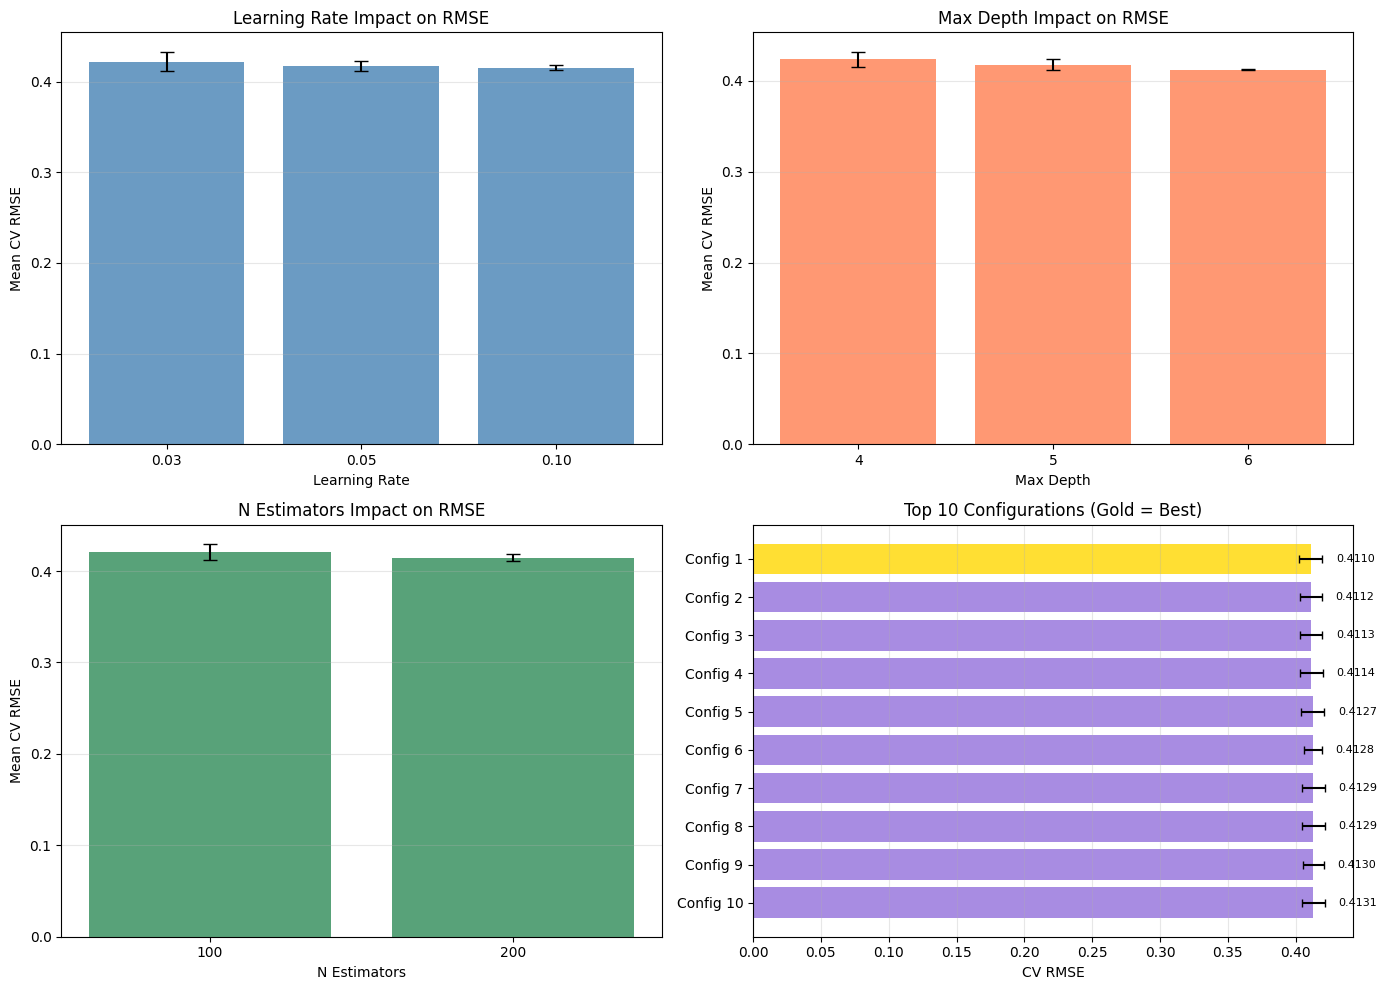


✓ Visualization saved to: ../data/xgboost_model_optimized/hyperparameter_search_results.png


In [11]:
# Visualize Hyperparameter Search Results
print("\n" + "="*60)
print("HYPERPARAMETER SEARCH VISUALIZATION")
print("="*60)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Learning Rate vs RMSE
if 'param_learning_rate' in cv_results.columns:
    ax1 = axes[0, 0]
    lr_results = cv_results.groupby('param_learning_rate')['mean_rmse'].agg(['mean', 'std'])
    ax1.bar(range(len(lr_results)), lr_results['mean'], yerr=lr_results['std'], 
            color='steelblue', capsize=5, alpha=0.8)
    ax1.set_xticks(range(len(lr_results)))
    ax1.set_xticklabels([f'{x:.2f}' for x in lr_results.index])
    ax1.set_xlabel('Learning Rate')
    ax1.set_ylabel('Mean CV RMSE')
    ax1.set_title('Learning Rate Impact on RMSE')
    ax1.grid(axis='y', alpha=0.3)

# 2. Max Depth vs RMSE
if 'param_max_depth' in cv_results.columns:
    ax2 = axes[0, 1]
    depth_results = cv_results.groupby('param_max_depth')['mean_rmse'].agg(['mean', 'std'])
    ax2.bar(range(len(depth_results)), depth_results['mean'], yerr=depth_results['std'],
            color='coral', capsize=5, alpha=0.8)
    ax2.set_xticks(range(len(depth_results)))
    ax2.set_xticklabels([str(int(x)) for x in depth_results.index])
    ax2.set_xlabel('Max Depth')
    ax2.set_ylabel('Mean CV RMSE')
    ax2.set_title('Max Depth Impact on RMSE')
    ax2.grid(axis='y', alpha=0.3)

# 3. N Estimators vs RMSE
if 'param_n_estimators' in cv_results.columns:
    ax3 = axes[1, 0]
    est_results = cv_results.groupby('param_n_estimators')['mean_rmse'].agg(['mean', 'std'])
    ax3.bar(range(len(est_results)), est_results['mean'], yerr=est_results['std'],
            color='seagreen', capsize=5, alpha=0.8)
    ax3.set_xticks(range(len(est_results)))
    ax3.set_xticklabels([str(int(x)) for x in est_results.index])
    ax3.set_xlabel('N Estimators')
    ax3.set_ylabel('Mean CV RMSE')
    ax3.set_title('N Estimators Impact on RMSE')
    ax3.grid(axis='y', alpha=0.3)

# 4. Top Configurations Comparison
ax4 = axes[1, 1]
top_n = min(10, len(cv_results_sorted))
top_configs = cv_results_sorted.head(top_n)
colors = ['gold' if i == 0 else 'mediumpurple' for i in range(top_n)]
bars = ax4.barh(range(top_n), top_configs['mean_rmse'], xerr=top_configs['std_rmse'], 
                color=colors, capsize=3, alpha=0.8)
ax4.set_yticks(range(top_n))
ax4.set_yticklabels([f"Config {i+1}" for i in range(top_n)])
ax4.set_xlabel('CV RMSE')
ax4.set_title(f'Top {top_n} Configurations (Gold = Best)')
ax4.invert_yaxis()
ax4.grid(axis='x', alpha=0.3)

# Add value labels
for i, (rmse, std) in enumerate(zip(top_configs['mean_rmse'], top_configs['std_rmse'])):
    ax4.text(rmse + std + 0.01, i, f'{rmse:.4f}', va='center', fontsize=8)

plt.tight_layout()

# Save the figure
viz_path = f"{optimized_model_path}/hyperparameter_search_results.png"
plt.savefig(viz_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Visualization saved to: {viz_path}")


In [12]:
# [BASELINE] Train XGBoost Model with Config Parameters
# Note: This cell uses the manual Config parameters as baseline.
# For optimized parameters, see cells 6-10 above which use GridSearchCV.
print("\n[BASELINE] Training XGBoost model with Config parameters...")

# Create validation set for monitoring
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, 
    test_size=config.VALIDATION_SIZE, 
    random_state=config.RANDOM_STATE
)

print(f"  - Training set: {X_train_split.shape[0]:,} samples")
print(f"  - Validation set: {X_val_split.shape[0]:,} samples")

# XGBoost 3.x sklearn API
model = xgb.XGBRegressor(
    n_estimators=config.N_ESTIMATORS,
    max_depth=config.MAX_DEPTH,
    learning_rate=config.LEARNING_RATE,
    subsample=config.SUBSAMPLE,
    colsample_bytree=config.COL_SAMPLE_BY_TREE,
    min_child_weight=config.MIN_CHILD_WEIGHT,
    gamma=config.GAMMA,
    reg_alpha=config.REG_ALPHA,
    reg_lambda=config.REG_LAMBDA,
    random_state=config.RANDOM_STATE,
    objective='reg:squarederror',
    n_jobs=-1
)

# Train model
model.fit(X_train_split, y_train_split)

# Evaluate on validation set
val_pred = model.predict(X_val_split)
val_rmse = np.sqrt(mean_squared_error(y_val_split, val_pred))
print(f"  - Validation RMSE: {val_rmse:.4f}")

print(f"✓ Model trained successfully ({config.N_ESTIMATORS} iterations)")


[BASELINE] Training XGBoost model with Config parameters...
  - Training set: 40,328 samples
  - Validation set: 10,082 samples
  - Validation RMSE: 0.4124
✓ Model trained successfully (200 iterations)


In [13]:
# Generate Predictions (uses optimized model from cell 8)
print("\nGenerating predictions on test set...")
y_pred = model.predict(X_test)

# Clip predictions to valid rating range [1, 5]
y_pred = np.clip(y_pred, 1.0, 5.0)

# Create predictions DataFrame for display
predictions_df = pd.DataFrame({
    'user_id': test_df['user_id'].values,
    'item_id': test_df['item_id'].values,
    'rating': y_test,
    'prediction': y_pred
})

print("Sample Predictions:")
print(predictions_df.head(10).to_string(index=False))


Generating predictions on test set...
Sample Predictions:
 user_id  item_id  rating  prediction
   13497       22    4.49    4.133707
    7614     6588    4.62    4.269996
      29     2317    3.68    4.135144
   13131     1166    1.36    3.251669
   14631        9    4.40    3.010545
    4731     5110    3.90    4.091313
     825     5346    3.29    3.745374
   14301      618    4.39    2.559920
    2732     4448    3.05    3.786017
    3539      840    3.65    3.422693


In [14]:
# Calculate RMSE and Display Feature Importance
print("\nCalculating final metrics...")

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("------------------------------------------------")
print(f"Root Mean Square Error (RMSE): {rmse:.4f}")
print("------------------------------------------------")

# Contextual Interpretation
print(f"\nInterpretation:")
print(f"On average, the model's prediction is off by {rmse:.2f} stars.")
if rmse < 1.0:
    print(f"✓ Excellent! RMSE is below 1.0, which is considered good for a 5-star scale.")
else:
    print(f"For a 5-star scale, an RMSE below 1.0 is generally considered acceptable for a baseline.")

# Feature Importance
print("\nTop 15 Most Important Features:")
feature_importance = pd.DataFrame({
    'feature': available_features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance.head(15).to_string(index=False))

# Calculate additional metrics
print("\nAdditional Metrics:")
mae = np.mean(np.abs(y_test - y_pred))
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Rating: {np.mean(y_test):.4f}")
print(f"Std Rating: {np.std(y_test):.4f}")



Calculating final metrics...
------------------------------------------------
Root Mean Square Error (RMSE): 0.9048
------------------------------------------------

Interpretation:
On average, the model's prediction is off by 0.90 stars.
✓ Excellent! RMSE is below 1.0, which is considered good for a 5-star scale.

Top 15 Most Important Features:
                feature  importance
        user_avg_rating    0.549360
        item_avg_rating    0.129349
        item_max_rating    0.068096
        user_max_rating    0.064124
item_avg_x_review_score    0.054227
        user_min_rating    0.029798
        item_min_rating    0.015507
        user_rating_std    0.014187
                item_id    0.007860
      item_review_count    0.006978
         minimum_nights    0.006279
        item_rating_std    0.005910
      host_is_superhost    0.003863
              bed_ratio    0.003085
      number_of_reviews    0.002959

Additional Metrics:
Mean Absolute Error (MAE): 0.6769
Mean Rating: 2.9995

In [15]:
# Save the OPTIMIZED model for future use
print(f"\nSaving optimized model to {optimized_model_path}...")
os.makedirs(optimized_model_path, exist_ok=True)
model.save_model(f"{optimized_model_path}/xgboost_model.json")

# Save feature importance for optimized model
feature_importance = pd.DataFrame({
    'feature': available_features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

# Save comprehensive model info with CV results
model_info = {
    'feature_names': available_features,
    'categorical_columns': list(label_encoders.keys()),
    'test_rmse': float(rmse),
    'test_mae': float(mae),
    'cv_rmse': float(best_cv_rmse),
    'cv_std': float(cv_results.loc[best_idx, 'std_test_score']),
    'n_features': len(available_features),
    'optimal_hyperparameters': search.best_params_,
    'search_info': {
        'method': 'RandomizedSearchCV' if USE_RANDOMIZED_SEARCH else 'GridSearchCV',
        'cv_folds': CV_FOLDS,
        'n_iterations': N_ITER_RANDOM if USE_RANDOMIZED_SEARCH else 'full_grid',
        'duration_seconds': duration
    },
    'comparison': {
        'baseline_rmse': baseline_rmse,
        'improvement_percent': float(improvement)
    }
}

with open(f"{optimized_model_path}/model_info.json", 'w') as f:
    json.dump(model_info, f, indent=2)

# Save feature importance
feature_importance.to_csv(f"{optimized_model_path}/feature_importance.csv", index=False)

# Save CV results
cv_results_sorted.to_csv(f"{optimized_model_path}/cv_results.csv", index=False)

print("✓ Optimized model saved successfully")
print(f"  - Model: {optimized_model_path}/xgboost_model.json")
print(f"  - Config: {optimized_model_path}/optimal_config.json")
print(f"  - Info: {optimized_model_path}/model_info.json")
print(f"  - Feature importance: {optimized_model_path}/feature_importance.csv")
print(f"  - CV results: {optimized_model_path}/cv_results.csv")
print(f"  - Visualization: {optimized_model_path}/hyperparameter_search_results.png")



Saving optimized model to ../data/xgboost_model_optimized...
✓ Optimized model saved successfully
  - Model: ../data/xgboost_model_optimized/xgboost_model.json
  - Config: ../data/xgboost_model_optimized/optimal_config.json
  - Info: ../data/xgboost_model_optimized/model_info.json
  - Feature importance: ../data/xgboost_model_optimized/feature_importance.csv
  - CV results: ../data/xgboost_model_optimized/cv_results.csv
  - Visualization: ../data/xgboost_model_optimized/hyperparameter_search_results.png
